In [33]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
import multiprocessing as mp
import itertools
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, train_test_split
from hyperopt import hp,STATUS_OK,Trials,fmin,tpe
from hyperopt.early_stop import no_progress_loss
from matplotlib import pyplot as plt
import warnings
from copy import deepcopy
import seaborn as sns
warnings.filterwarnings("ignore")

In [13]:
# --------------------------------------------train set-----------------------------
data_1=data_1[data_1["AGE"]>=18]

data_1['F']=((data_1['L_F']==1)|(data_1['R_F']==1))+0
data_1['T']=((data_1['L_T']==1)|(data_1['R_T']==1))+0
data_1['P']=((data_1['L_P']==1)|(data_1['R_P']==1))+0
data_1['O']=((data_1['L_O']==1)|(data_1['R_O']==1))+0
data_1['I']=((data_1['L_I']==1)|(data_1['R_I']==1))+0
data_1['CC']=((data_1['L_CC']==1)|(data_1['R_CC']==1))+0
data_1['BG']=((data_1['L_BG']==1)|(data_1['R_BG']==1))+0
data_1['TH']=((data_1['L_TH']==1)|(data_1['R_TH']==1))+0
data_1['M']=((data_1['L_M']==1)|(data_1['R_M']==1))+0
data_1['S']=((data_1['L_S']==1)|(data_1['R_S']==1))+0
data_1['H']=((data_1['L_H']==1)|(data_1['R_H']==1))+0
data_1['GC']=((data_1['L_GC']==1)|(data_1['R_GC']==1))+0
data_1['BILATERAL']=((data_1['L']+data_1['R']) == 2) + 0


loco_lob = ['F','T','P','O','I','CC','BG','TH']
loco_lr=['F','T','P','O','I','CC','BG','TH','M','S','H','GC']
loco=['L_F','L_T','L_P','L_O','L_I','L_CC','L_BG','L_TH','L_M','L_S','L_H','L_GC',
      'R_F','R_T','R_P','R_O','R_I','R_CC','R_BG','R_TH','R_M','R_S','R_H','R_GC'] 
loco_a=['L_F','L_T','L_P','L_O','L_I','L_CC','L_BG','L_TH','L_M','L_S','L_H','L_GC',
        'R_F','R_T','R_P','R_O','R_I','R_CC','R_BG','R_TH','R_M','R_S','R_H','R_GC', 
        'F','T','P','O','I','CC','BG','TH','M','S','H','GC']
#sym
symp_p = ['S_I_P','S_M_P','S_S_P','S_Ap_P','S_Cog_P','S_H_P','S_E_P','S_Con_P','S_Ab_P','S_V_P','S_Au_P','S_D_P']
symp_s = ['S_I','S_M','S_S','S_Ap','S_Cog','S_H','S_E','S_Con','S_Ab','S_V','S_Au','S_D']
symp_p_only = []
[symp_p_only.append(sy + '_ONLY') for sy in symp_p]
symp_s_only = []
[symp_s_only.append(sy + '_ONLY') for sy in symp_s]
##sym_t
symp_t = ['S_T','S_ST','S_DT','S_ET','S_ST_RA', 'S_DT_RA','S_ET_RA']
symp_st = ['S_I_DIS_T','S_I_FOLL_T','S_M_T','S_S_T','S_AP_T','S_COG_T','S_H_T','S_E_T','S_CON_T','S_ABD_T','S_V_T','S_DIZ_T','S_AUD_T']
symp_st_ra = []
[symp_st_ra.append((sy_st + '_RA')) for sy_st in symp_st]
symp_st_a = symp_st + symp_st_ra

#  feature engineering
data_1.index = range(len(data_1))
data_1['NUM_L'] = 0
data_1['LOCALIZED'] = 0
data_1['S_NUM_P'] = 0
data_1['S_NUM_S'] = 0
data_1['S_P_ONLY'] = 0
data_1['S_S_ONLY'] = 0
data_1['S_I'] = data_1['S_I_P']
for sy in symp_p:
    data_1[sy + '_ONLY'] = 0    
for sy in symp_s:
    data_1[sy + '_ONLY'] = 0
data_1['S_ST_RA'] = 0
data_1['S_DT_RA'] = 0
data_1['S_ET_RA'] = 0
for sy in symp_st:
    data_1[sy + '_RA'] = 0
for i in range(len(data_1)):
    # num_lobs       
    for lo in loco_lob:
        if data_1[lo][i]>0:
            data_1.loc[i, 'NUM_L'] += 1
    # localized (num_l = 1)
    if data_1.loc[i, 'NUM_L'] == 1:
        data_1.loc[i, 'LOCALIZED'] = 1
    # sy_t_ratio  
    for sy in symp_st:
        data_1.loc[i, sy+'_RA'] = data_1[sy][i] / data_1['S_T'][i]
    #ST_RA
    data_1.loc[i, 'S_ST_RA'] = data_1['S_ST'][i] / data_1['S_T'][i]
    data_1.loc[i, 'S_DT_RA'] = data_1['S_DT'][i] / data_1['S_T'][i]
    data_1.loc[i, 'S_ET_RA'] = data_1['S_ET'][i] / data_1['S_T'][i]
    # sy_num
    for sy_p in symp_p:
        data_1.loc[i, 'S_NUM_P'] += data_1[sy_p][i]                
    for sy_s in symp_s:
        data_1.loc[i, 'S_NUM_S'] += data_1[sy_s][i]
    # sym_only******
    data_1.loc[i, 'S_P_ONLY'] = 1 - (data_1['S_NUM_P'][i] > 1)           
    for sy in symp_p:
        data_1.loc[i, sy + '_ONLY'] = data_1[sy][i] * data_1['S_P_ONLY'][i]
          
    data_1.loc[i, 'S_S_ONLY'] = 1 - (data_1['S_NUM_S'][i] > 1)              
    for sy in symp_s:
        data_1.loc[i, sy + '_ONLY'] = data_1[sy][i] * data_1['S_S_ONLY'][i]  
data_1 = data_1.drop('S_I',axis = 1)

In [4]:
x_1 = deepcopy(data_1)
y_1 = x_1['GRADE']
x_1 = x_1.drop(['P_IDH','P_TERT','P_CD','P_MGMT','GRADE',"ID"], axis = 1)
y_1 = np.squeeze(np.array(y_1))
y_1[y_1 < 4] = 0
y_1[y_1 == 4] = 1


In [5]:
def hocv(params,n):
    x_train, x_val, y_train, y_val=train_test_split(train_data, train_label, train_size = 0.8, random_state= n, stratify= train_label)
    clf = XGBClassifier(n_estimators = int(params['n_estimators']), max_depth = int(params['max_depth']), 
                        learning_rate = params['learning_rate'], min_child_weight = int(params['min_child_weight']),
                        gamma = params['gamma'], subsample = params['subsample'], random_state = 123) 
    clf.fit(x_train,y_train)
    probs = clf.predict_proba(x_val)
    auc_n = metrics.roc_auc_score(y_val,probs[:, 1])
    return auc_n 
def hocv_(par):
    
    return hocv(par[0],par[1])
def hyperopt_xgb(params):
    par = list(itertools.product([params],range(100)))
    if __name__ == '__main__': 
        with mp.Pool() as pool:
            auc_i=pool.map(hocv_, par)
    auc_m = np.mean(auc_i)
    return -auc_m 
def param_hyperopt(max_eval=100):
    trials = Trials()
    # early_stop_f = no_progress_loss(100)
    params_best = fmin(hyperopt_xgb,
                       space = space4xgc,
                       max_evals = max_eval,
                       algo =tpe.suggest,
                       verbose = True,
                       trials = trials)
                       #early_stop_fn = early_stop_f)
    print('\n','\n','best params:', params_best,'\n')
    return params_best, trials

In [6]:
n_list = list(range(100))
space4xgc = {
    'learning_rate': hp.uniform('learning_rate', 0.01,0.3),   
    'n_estimators': hp.quniform('n_estimators',50,500,25),  
    'max_depth': hp.quniform('max_depth',1,10,1),
    'min_child_weight':hp.quniform('min_child_weight',1,6,1),
    'gamma': hp.uniform('gamma',0,0.6),
    'subsample': hp.uniform('subsample',0.5,1)   
}  

In [7]:
train_data = x_1
train_label = y_1

In [8]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [2:40:45<00:00, 96.46s/trial, best loss: -0.8866121784069206]

 
 best params: {'gamma': 0.33944095970485727, 'learning_rate': 0.07231147755753731, 'max_depth': 1.0, 'min_child_weight': 3.0, 'n_estimators': 400.0, 'subsample': 0.6265554053485686} 



In [9]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [2:28:57<00:00, 89.38s/trial, best loss: -0.8857780024716324]

 
 best params: {'gamma': 0.07900908011746272, 'learning_rate': 0.01541181334571437, 'max_depth': 4.0, 'min_child_weight': 3.0, 'n_estimators': 475.0, 'subsample': 0.760454462788773} 



In [10]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:50:17<00:00, 66.17s/trial, best loss: -0.8861779575328615]

 
 best params: {'gamma': 0.3943504398383251, 'learning_rate': 0.031233162089099868, 'max_depth': 3.0, 'min_child_weight': 2.0, 'n_estimators': 225.0, 'subsample': 0.7658453388609228} 



In [11]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:45:58<00:00, 63.59s/trial, best loss: -0.8859684305134253]

 
 best params: {'gamma': 0.5175268992337766, 'learning_rate': 0.091756135802919, 'max_depth': 1.0, 'min_child_weight': 5.0, 'n_estimators': 325.0, 'subsample': 0.9588137607700449} 



In [14]:
x_1 = deepcopy(data_1)
y_1 = x_1['GRADE']
x_1 = x_1.drop(['P_IDH','P_TERT','P_CD','P_MGMT','GRADE',"ID"], axis = 1)
fea_sel = ['S_NUM_S', 'S_H_T_RA', 'S_E_T', 'S_E_T_RA', 'AGE', 'S_H_T', 'S_M_T_RA', 'S_ET_RA', 
           'S_M_T', 'F', 'S_T', 'S_AP_T', 'I', 'SEX', 'S_ST', 'S_ABD_T', 'S_ET', 'R_T'] #18 significant feature seled in > 85% procedures of 7000 HOCV and gained best mean AUC of 0.8800
x_1 = x_1[fea_sel]
y_1 = np.squeeze(np.array(y_1))
y_1[y_1 < 4] = 0
y_1[y_1 == 4] = 1

In [16]:
train_data = x_1
train_label = y_1

In [17]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:45:32<00:00, 63.33s/trial, best loss: -0.8886102685091565]

 
 best params: {'gamma': 0.1449130597289839, 'learning_rate': 0.07354100488338675, 'max_depth': 1.0, 'min_child_weight': 2.0, 'n_estimators': 375.0, 'subsample': 0.5402156823861879} 



In [18]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:31:37<00:00, 54.98s/trial, best loss: -0.8880446017301427]

 
 best params: {'gamma': 0.2756158123013734, 'learning_rate': 0.08739167913929419, 'max_depth': 1.0, 'min_child_weight': 3.0, 'n_estimators': 300.0, 'subsample': 0.5517996400094436} 



In [19]:
n_list = list(range(100))
space4xgc = {
    'learning_rate': hp.uniform('learning_rate', 0.07,0.09),   
    'n_estimators': hp.quniform('n_estimators',275,400,5),  
    'max_depth': 1,
    'min_child_weight':hp.quniform('min_child_weight',2,3,1),
    'gamma': hp.uniform('gamma',0.1,0.3),
    'subsample': hp.uniform('subsample',0.5,1)   
}  

In [20]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:10:53<00:00, 42.54s/trial, best loss: -0.8886394787102573]

 
 best params: {'gamma': 0.23956164365283508, 'learning_rate': 0.07061970843977974, 'min_child_weight': 2.0, 'n_estimators': 350.0, 'subsample': 0.5073258213194702} 



In [21]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:10:35<00:00, 42.35s/trial, best loss: -0.8887102572744635]

 
 best params: {'gamma': 0.16891422634011036, 'learning_rate': 0.08427861669466527, 'min_child_weight': 2.0, 'n_estimators': 385.0, 'subsample': 0.5511240536292172} 



In [22]:
clf = XGBClassifier(gamma = 0.1689, learning_rate = 0.0843, max_depth = 1, min_child_weight = 2, n_estimators = 385, subsample = 0.5511, random_state=123)

In [24]:
auc_7000HOCV = []
n_list = list(itertools.product([0.8,0.7,0.6,0.5,0.4,0.3,0.2],range(1000)))
for i in range(7000):
    x_train, x_val, y_train, y_val=train_test_split(x_1, y_1, train_size = n_list[i][0] , random_state= n_list[i][1], stratify= y_1)
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(x_val)
    auc_i = metrics.roc_auc_score(y_val,probs[:,1])
    auc_7000HOCV.append(auc_i) 
    print(n_list[i])

(0.8, 0)
(0.8, 1)
(0.8, 2)
(0.8, 3)
(0.8, 4)
(0.8, 5)
(0.8, 6)
(0.8, 7)
(0.8, 8)
(0.8, 9)
(0.8, 10)
(0.8, 11)
(0.8, 12)
(0.8, 13)
(0.8, 14)
(0.8, 15)
(0.8, 16)
(0.8, 17)
(0.8, 18)
(0.8, 19)
(0.8, 20)
(0.8, 21)
(0.8, 22)
(0.8, 23)
(0.8, 24)
(0.8, 25)
(0.8, 26)
(0.8, 27)
(0.8, 28)
(0.8, 29)
(0.8, 30)
(0.8, 31)
(0.8, 32)
(0.8, 33)
(0.8, 34)
(0.8, 35)
(0.8, 36)
(0.8, 37)
(0.8, 38)
(0.8, 39)
(0.8, 40)
(0.8, 41)
(0.8, 42)
(0.8, 43)
(0.8, 44)
(0.8, 45)
(0.8, 46)
(0.8, 47)
(0.8, 48)
(0.8, 49)
(0.8, 50)
(0.8, 51)
(0.8, 52)
(0.8, 53)
(0.8, 54)
(0.8, 55)
(0.8, 56)
(0.8, 57)
(0.8, 58)
(0.8, 59)
(0.8, 60)
(0.8, 61)
(0.8, 62)
(0.8, 63)
(0.8, 64)
(0.8, 65)
(0.8, 66)
(0.8, 67)
(0.8, 68)
(0.8, 69)
(0.8, 70)
(0.8, 71)
(0.8, 72)
(0.8, 73)
(0.8, 74)
(0.8, 75)
(0.8, 76)
(0.8, 77)
(0.8, 78)
(0.8, 79)
(0.8, 80)
(0.8, 81)
(0.8, 82)
(0.8, 83)
(0.8, 84)
(0.8, 85)
(0.8, 86)
(0.8, 87)
(0.8, 88)
(0.8, 89)
(0.8, 90)
(0.8, 91)
(0.8, 92)
(0.8, 93)
(0.8, 94)
(0.8, 95)
(0.8, 96)
(0.8, 97)
(0.8, 98)
(0.8, 99)
(0.8, 100)

In [25]:
auc_7000HOCV_mean = np.mean(auc_7000HOCV)
auc_7000HOCV_std = np.std(auc_7000HOCV)
print('mean value of auc in 7000HOCV is:',auc_7000HOCV_mean,'\nstd of auc in 7000HOCV is:',auc_7000HOCV_std,'\n95% CI is:(',auc_7000HOCV_mean - auc_7000HOCV_std * 1.96,', ', auc_7000HOCV_mean + auc_7000HOCV_std * 1.96, ')')

mean value of auc in 7000HOCV is: 0.8799959607273363 
std of auc in 7000HOCV is: 0.01657792157381988 
95% CI is:( 0.8475032344426494 ,  0.9124886870120232 )


In [26]:
clf= XGBClassifier(gamma = 0.3394, learning_rate = 0.0723, max_depth = 1, min_child_weight = 3, n_estimators = 400, subsample = 0.6266, random_state=123)

In [32]:
auc_7000HOCV = []
prob_7000HOCV = []
y_7000HOCV = []
n_list = n_list = list(itertools.product([0.8,0.7,0.6,0.5,0.4,0.3,0.2],range(1000)))
for i in range(7000):
    x_train, x_val, y_train, y_val=train_test_split(x_1, y_1, train_size = n_list[i][0] , random_state= n_list[i][1], stratify= y_1)
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(x_val)
    for n in range(len(y_val)):
        y_7000HOCV.append(y_val[n])
        prob_7000HOCV.append(probs[n,1])
    auc_i = metrics.roc_auc_score(y_val,probs[:,1])
    auc_7000HOCV.append(auc_i) 
    print(n_list[i])

(0.8, 0)
(0.8, 1)
(0.8, 2)
(0.8, 3)
(0.8, 4)
(0.8, 5)
(0.8, 6)
(0.8, 7)
(0.8, 8)
(0.8, 9)
(0.8, 10)
(0.8, 11)
(0.8, 12)
(0.8, 13)
(0.8, 14)
(0.8, 15)
(0.8, 16)
(0.8, 17)
(0.8, 18)
(0.8, 19)
(0.8, 20)
(0.8, 21)
(0.8, 22)
(0.8, 23)
(0.8, 24)
(0.8, 25)
(0.8, 26)
(0.8, 27)
(0.8, 28)
(0.8, 29)
(0.8, 30)
(0.8, 31)
(0.8, 32)
(0.8, 33)
(0.8, 34)
(0.8, 35)
(0.8, 36)
(0.8, 37)
(0.8, 38)
(0.8, 39)
(0.8, 40)
(0.8, 41)
(0.8, 42)
(0.8, 43)
(0.8, 44)
(0.8, 45)
(0.8, 46)
(0.8, 47)
(0.8, 48)
(0.8, 49)
(0.8, 50)
(0.8, 51)
(0.8, 52)
(0.8, 53)
(0.8, 54)
(0.8, 55)
(0.8, 56)
(0.8, 57)
(0.8, 58)
(0.8, 59)
(0.8, 60)
(0.8, 61)
(0.8, 62)
(0.8, 63)
(0.8, 64)
(0.8, 65)
(0.8, 66)
(0.8, 67)
(0.8, 68)
(0.8, 69)
(0.8, 70)
(0.8, 71)
(0.8, 72)
(0.8, 73)
(0.8, 74)
(0.8, 75)
(0.8, 76)
(0.8, 77)
(0.8, 78)
(0.8, 79)
(0.8, 80)
(0.8, 81)
(0.8, 82)
(0.8, 83)
(0.8, 84)
(0.8, 85)
(0.8, 86)
(0.8, 87)
(0.8, 88)
(0.8, 89)
(0.8, 90)
(0.8, 91)
(0.8, 92)
(0.8, 93)
(0.8, 94)
(0.8, 95)
(0.8, 96)
(0.8, 97)
(0.8, 98)
(0.8, 99)
(0.8, 100)

In [159]:
n_list = list(itertools.product([0.8,0.7,0.6,0.5,0.4,0.3,0.2],range(1000)))

In [28]:
auc_7000HOCV_mean = np.mean(auc_7000HOCV)
auc_7000HOCV_std = np.std(auc_7000HOCV)
print('mean value of auc in 7000HOCV is:',auc_7000HOCV_mean,'\nstd of auc in 7000HOCV is:',auc_7000HOCV_std,'\n95% CI is:(',auc_7000HOCV_mean - auc_7000HOCV_std * 1.96,', ', auc_7000HOCV_mean + auc_7000HOCV_std * 1.96, ')')

mean value of auc in 7000HOCV is: 0.8800267679876671 
std of auc in 7000HOCV is: 0.01672344850245118 
95% CI is:( 0.8472488089228628 ,  0.9128047270524714 )


In [29]:
# --------------------prospective set----------------------
data_2=data_2[data_2["AGE"]>=18]

data_2['F']=((data_2['L_F']==1)|(data_2['R_F']==1))+0
data_2['T']=((data_2['L_T']==1)|(data_2['R_T']==1))+0
data_2['P']=((data_2['L_P']==1)|(data_2['R_P']==1))+0
data_2['O']=((data_2['L_O']==1)|(data_2['R_O']==1))+0
data_2['I']=((data_2['L_I']==1)|(data_2['R_I']==1))+0
data_2['CC']=((data_2['L_CC']==1)|(data_2['R_CC']==1))+0
data_2['BG']=((data_2['L_BG']==1)|(data_2['R_BG']==1))+0
data_2['TH']=((data_2['L_TH']==1)|(data_2['R_TH']==1))+0
data_2['M']=((data_2['L_M']==1)|(data_2['R_M']==1))+0
data_2['S']=((data_2['L_S']==1)|(data_2['R_S']==1))+0
data_2['H']=((data_2['L_H']==1)|(data_2['R_H']==1))+0
data_2['GC']=((data_2['L_GC']==1)|(data_2['R_GC']==1))+0
data_2['BILATERAL']=((data_2['L']+data_2['R']) == 2) + 0


loco_lob = ['F','T','P','O','I','CC','BG','TH']
loco_lr=['F','T','P','O','I','CC','BG','TH','M','S','H','GC']
loco=['L_F','L_T','L_P','L_O','L_I','L_CC','L_BG','L_TH','L_M','L_S','L_H','L_GC',
      'R_F','R_T','R_P','R_O','R_I','R_CC','R_BG','R_TH','R_M','R_S','R_H','R_GC'] 
loco_a=['L_F','L_T','L_P','L_O','L_I','L_CC','L_BG','L_TH','L_M','L_S','L_H','L_GC',
        'R_F','R_T','R_P','R_O','R_I','R_CC','R_BG','R_TH','R_M','R_S','R_H','R_GC', 
        'F','T','P','O','I','CC','BG','TH','M','S','H','GC']
#sym
symp_p = ['S_I_P','S_M_P','S_S_P','S_Ap_P','S_Cog_P','S_H_P','S_E_P','S_Con_P','S_Ab_P','S_V_P','S_Au_P','S_D_P']
symp_s = ['S_I','S_M','S_S','S_Ap','S_Cog','S_H','S_E','S_Con','S_Ab','S_V','S_Au','S_D']
symp_p_only = []
[symp_p_only.append(sy + '_ONLY') for sy in symp_p]
symp_s_only = []
[symp_s_only.append(sy + '_ONLY') for sy in symp_s]
##sym_t
symp_t = ['S_T','S_ST','S_DT','S_ET','S_ST_RA', 'S_DT_RA','S_ET_RA']
symp_st = ['S_I_DIS_T','S_I_FOLL_T','S_M_T','S_S_T','S_AP_T','S_COG_T','S_H_T','S_E_T','S_CON_T','S_ABD_T','S_V_T','S_DIZ_T','S_AUD_T']
symp_st_ra = []
[symp_st_ra.append((sy_st + '_RA')) for sy_st in symp_st]
symp_st_a = symp_st + symp_st_ra

#  feature engineering
data_2.index = range(len(data_2))
data_2['NUM_L'] = 0
data_2['LOCALIZED'] = 0
data_2['S_NUM_P'] = 0
data_2['S_NUM_S'] = 0
data_2['S_P_ONLY'] = 0
data_2['S_S_ONLY'] = 0
data_2['S_I'] = data_2['S_I_P']
for sy in symp_p:
    data_2[sy + '_ONLY'] = 0    
for sy in symp_s:
    data_2[sy + '_ONLY'] = 0
data_2['S_ST_RA'] = 0
data_2['S_DT_RA'] = 0
data_2['S_ET_RA'] = 0
for sy in symp_st:
    data_2[sy + '_RA'] = 0
for i in range(len(data_2)):
    # num_lobs       
    for lo in loco_lob:
        if data_2[lo][i]>0:
            data_2.loc[i, 'NUM_L'] += 1
    # localized (num_l = 1)
    if data_2.loc[i, 'NUM_L'] == 1:
        data_2.loc[i, 'LOCALIZED'] = 1
    # sy_t_ratio  
    for sy in symp_st:
        data_2.loc[i, sy+'_RA'] = data_2[sy][i] / data_2['S_T'][i]
    #ST_RA
    data_2.loc[i, 'S_ST_RA'] = data_2['S_ST'][i] / data_2['S_T'][i]
    data_2.loc[i, 'S_DT_RA'] = data_2['S_DT'][i] / data_2['S_T'][i]
    data_2.loc[i, 'S_ET_RA'] = data_2['S_ET'][i] / data_2['S_T'][i]
    # sy_num
    for sy_p in symp_p:
        data_2.loc[i, 'S_NUM_P'] += data_2[sy_p][i]                
    for sy_s in symp_s:
        data_2.loc[i, 'S_NUM_S'] += data_2[sy_s][i]
    # sym_only******
    data_2.loc[i, 'S_P_ONLY'] = 1 - (data_2['S_NUM_P'][i] > 1)           
    for sy in symp_p:
        data_2.loc[i, sy + '_ONLY'] = data_2[sy][i] * data_2['S_P_ONLY'][i]
          
    data_2.loc[i, 'S_S_ONLY'] = 1 - (data_2['S_NUM_S'][i] > 1)              
    for sy in symp_s:
        data_2.loc[i, sy + '_ONLY'] = data_2[sy][i] * data_2['S_S_ONLY'][i]  
data_2 = data_2.drop('S_I',axis = 1)

In [30]:
x_2 = deepcopy(data_2)
y_2 = x_2['GRADE']
x_2 = x_2.drop(['P_IDH','P_TERT','P_CD','P_MGMT','GRADE',"ID"], axis = 1)
fea_sel = ['S_NUM_S', 'S_H_T_RA', 'S_E_T', 'S_E_T_RA', 'AGE', 'S_H_T', 'S_M_T_RA', 'S_ET_RA', 
           'S_M_T', 'F', 'S_T', 'S_AP_T', 'I', 'SEX', 'S_ST', 'S_ABD_T', 'S_ET', 'R_T'] #18 significant feature seled in > 85% procedures of 7000 HOCV and gained best mean AUC of 0.8800
x_2 = x_2[fea_sel]
y_2 = np.squeeze(np.array(y_2))
y_2[y_2 < 4] = 0
y_2[y_2 == 4] = 1

In [31]:
clf.fit(x_1, y_1)
probs_2 = clf.predict_proba(x_2)
auc_test = metrics.roc_auc_score(y_2,probs_2[:,1])
print('AUC on test set:',auc_test)

AUC on test set: 0.8800401779308366


plt

In [157]:
fpr_HOCV, tpr_HOCV, thr_HOCV = metrics.roc_curve(y_7000HOCV, prob_7000HOCV)
# fpr = pd.DataFrame(fpr, columns = ['1-Specifity'])
# tpr = pd.DataFrame(tpr, columns = ['Sensitivity'])
# roc_data = pd.concat([fpr, tpr], axis = 1)

In [155]:
recall_7000HOCV = []
fpr_7000HOCV = []
# n_pt=int(len(prob)*10%)
# probrange = np.linspace(min(prob_7000HOCV), max(prob_7000HOCV), num = 1000, endpoint=False)# if n_pt<50,num=50
for i in items:
    y_pred= []
    for j in range(len(prob_7000HOCV)): #generate pred for i
        if prob_7000HOCV[j]>i:
            y_pred.append(1)
        else:
            y_pred.append(0)
    cm = metrics.confusion_matrix(y_7000HOCV,y_pred,labels=[1,0])
    recall_7000HOCV.append(cm[0,0]/cm[0,:].sum())
    fpr_7000HOCV.append(cm[1,0]/cm[1,:].sum())
recall_7000HOCV.sort() #assending tp dessending
fpr_7000HOCV.sort()

KeyboardInterrupt: 

In [140]:
fpr_7000HOCV = pd.DataFrame(fpr_7000HOCV, columns = ['1-Specifity'])
recall_7000HOCV = pd.DataFrame(recall_7000HOCV, columns = ['Sensitivity'])
roc_data_7000HOCV = pd.concat([fpr_7000HOCV, recall_7000HOCV], axis = 1)

In [ ]:
fpr_7000HOCV

In [136]:
fpr_7000HOCV.iloc[0,0]

0.0008460368461488216

In [141]:
items = [fpr_7000HOCV.iloc[0,0]]
for i in range(len(fpr_7000HOCV) - 1):
    if fpr_7000HOCV.iloc[i,0] !=  fpr_7000HOCV.iloc[i + 1,0]:
        items.append(fpr_7000HOCV.iloc[i + 1,0])
    

In [84]:
roc_test

,1-Specifity,Sensitivity
0,0.000000,0.000000
1,0.000000,0.014493
2,0.000000,0.130435
3,0.009901,0.130435
4,0.009901,0.202899
5,0.019802,0.202899
6,0.019802,0.275362
7,0.029703,0.275362
8,0.029703,0.318841
9,0.039604,0.318841


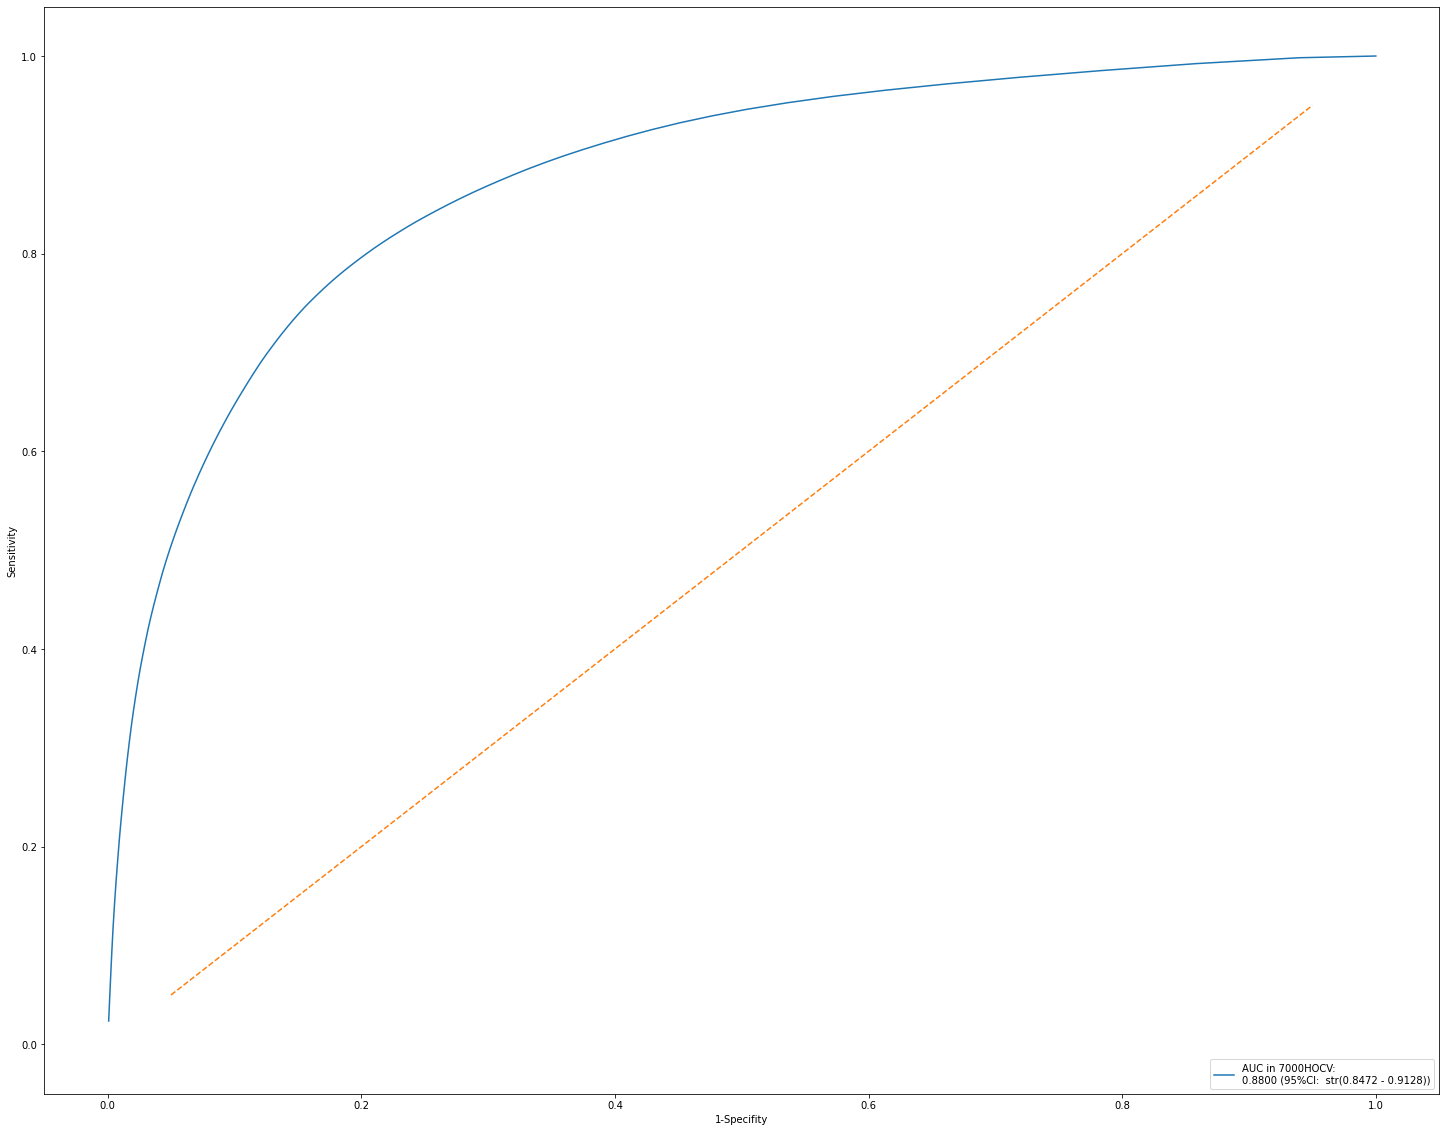

In [119]:
plt.figure(figsize=(25, 20))   
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
# sns.lineplot(data = roc_test, x = '1-Specifity', y = 'Sensitivity',label = 'AUC on test set: \n' + str('%.4f'%auc_test))
sns.lineplot(data = roc_data_7000HOCV, x = '1-Specifity', y = 'Sensitivity',label = 'AUC in 7000HOCV: \n' + str('%.4f'%auc_7000HOCV_mean) + ' (95%CI:  str(0.8472 - 0.9128))', ci = 95)
plt.plot([0.05,0.95],[0.05,0.95],linestyle='--') #y=x,refference line
plt.legend(loc='lower right')

In [79]:
fpr_test_ = pd.DataFrame(fpr_test, columns = ['1-Specifity'])
tpr_test_ = pd.DataFrame(tpr_test, columns = ['Sensitivity'])
roc_test = pd.concat([fpr_test_,tpr_test_],axis = 1)

In [46]:
auc_7000HOCV_mean +auc_7000HOCV_std * 1.96

0.9128047270524714

In [165]:
auc_bs = []
df_bs = pd.DataFrame(columns=['y', 'prob'])
df_bs.loc[:, 'y'] = y_2
df_bs.loc[:, 'prob'] = prob_test[:,1]
df_pos = df_bs[df_bs.y == 1]
df_neg = df_bs[df_bs.y == 0]
for i in range(7000):
    pos_sample = df_pos.sample(n = int(len(df_pos) * n_list[i][0]), replace=True, random_state = n_list[i][1])
    neg_sample = df_neg.sample(n = int(len(df_neg) * n_list[i][0]), replace=True, random_state = n_list[i][1])
    y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
    pred_sample = np.concatenate([pos_sample.prob.values, neg_sample.prob.values])   
    score = metrics.roc_auc_score(y_sample, pred_sample)
    auc_bs.append(score)

In [166]:
np.mean(auc_bs)

0.8808123767614859

In [167]:
auc_test

0.8800401779308366

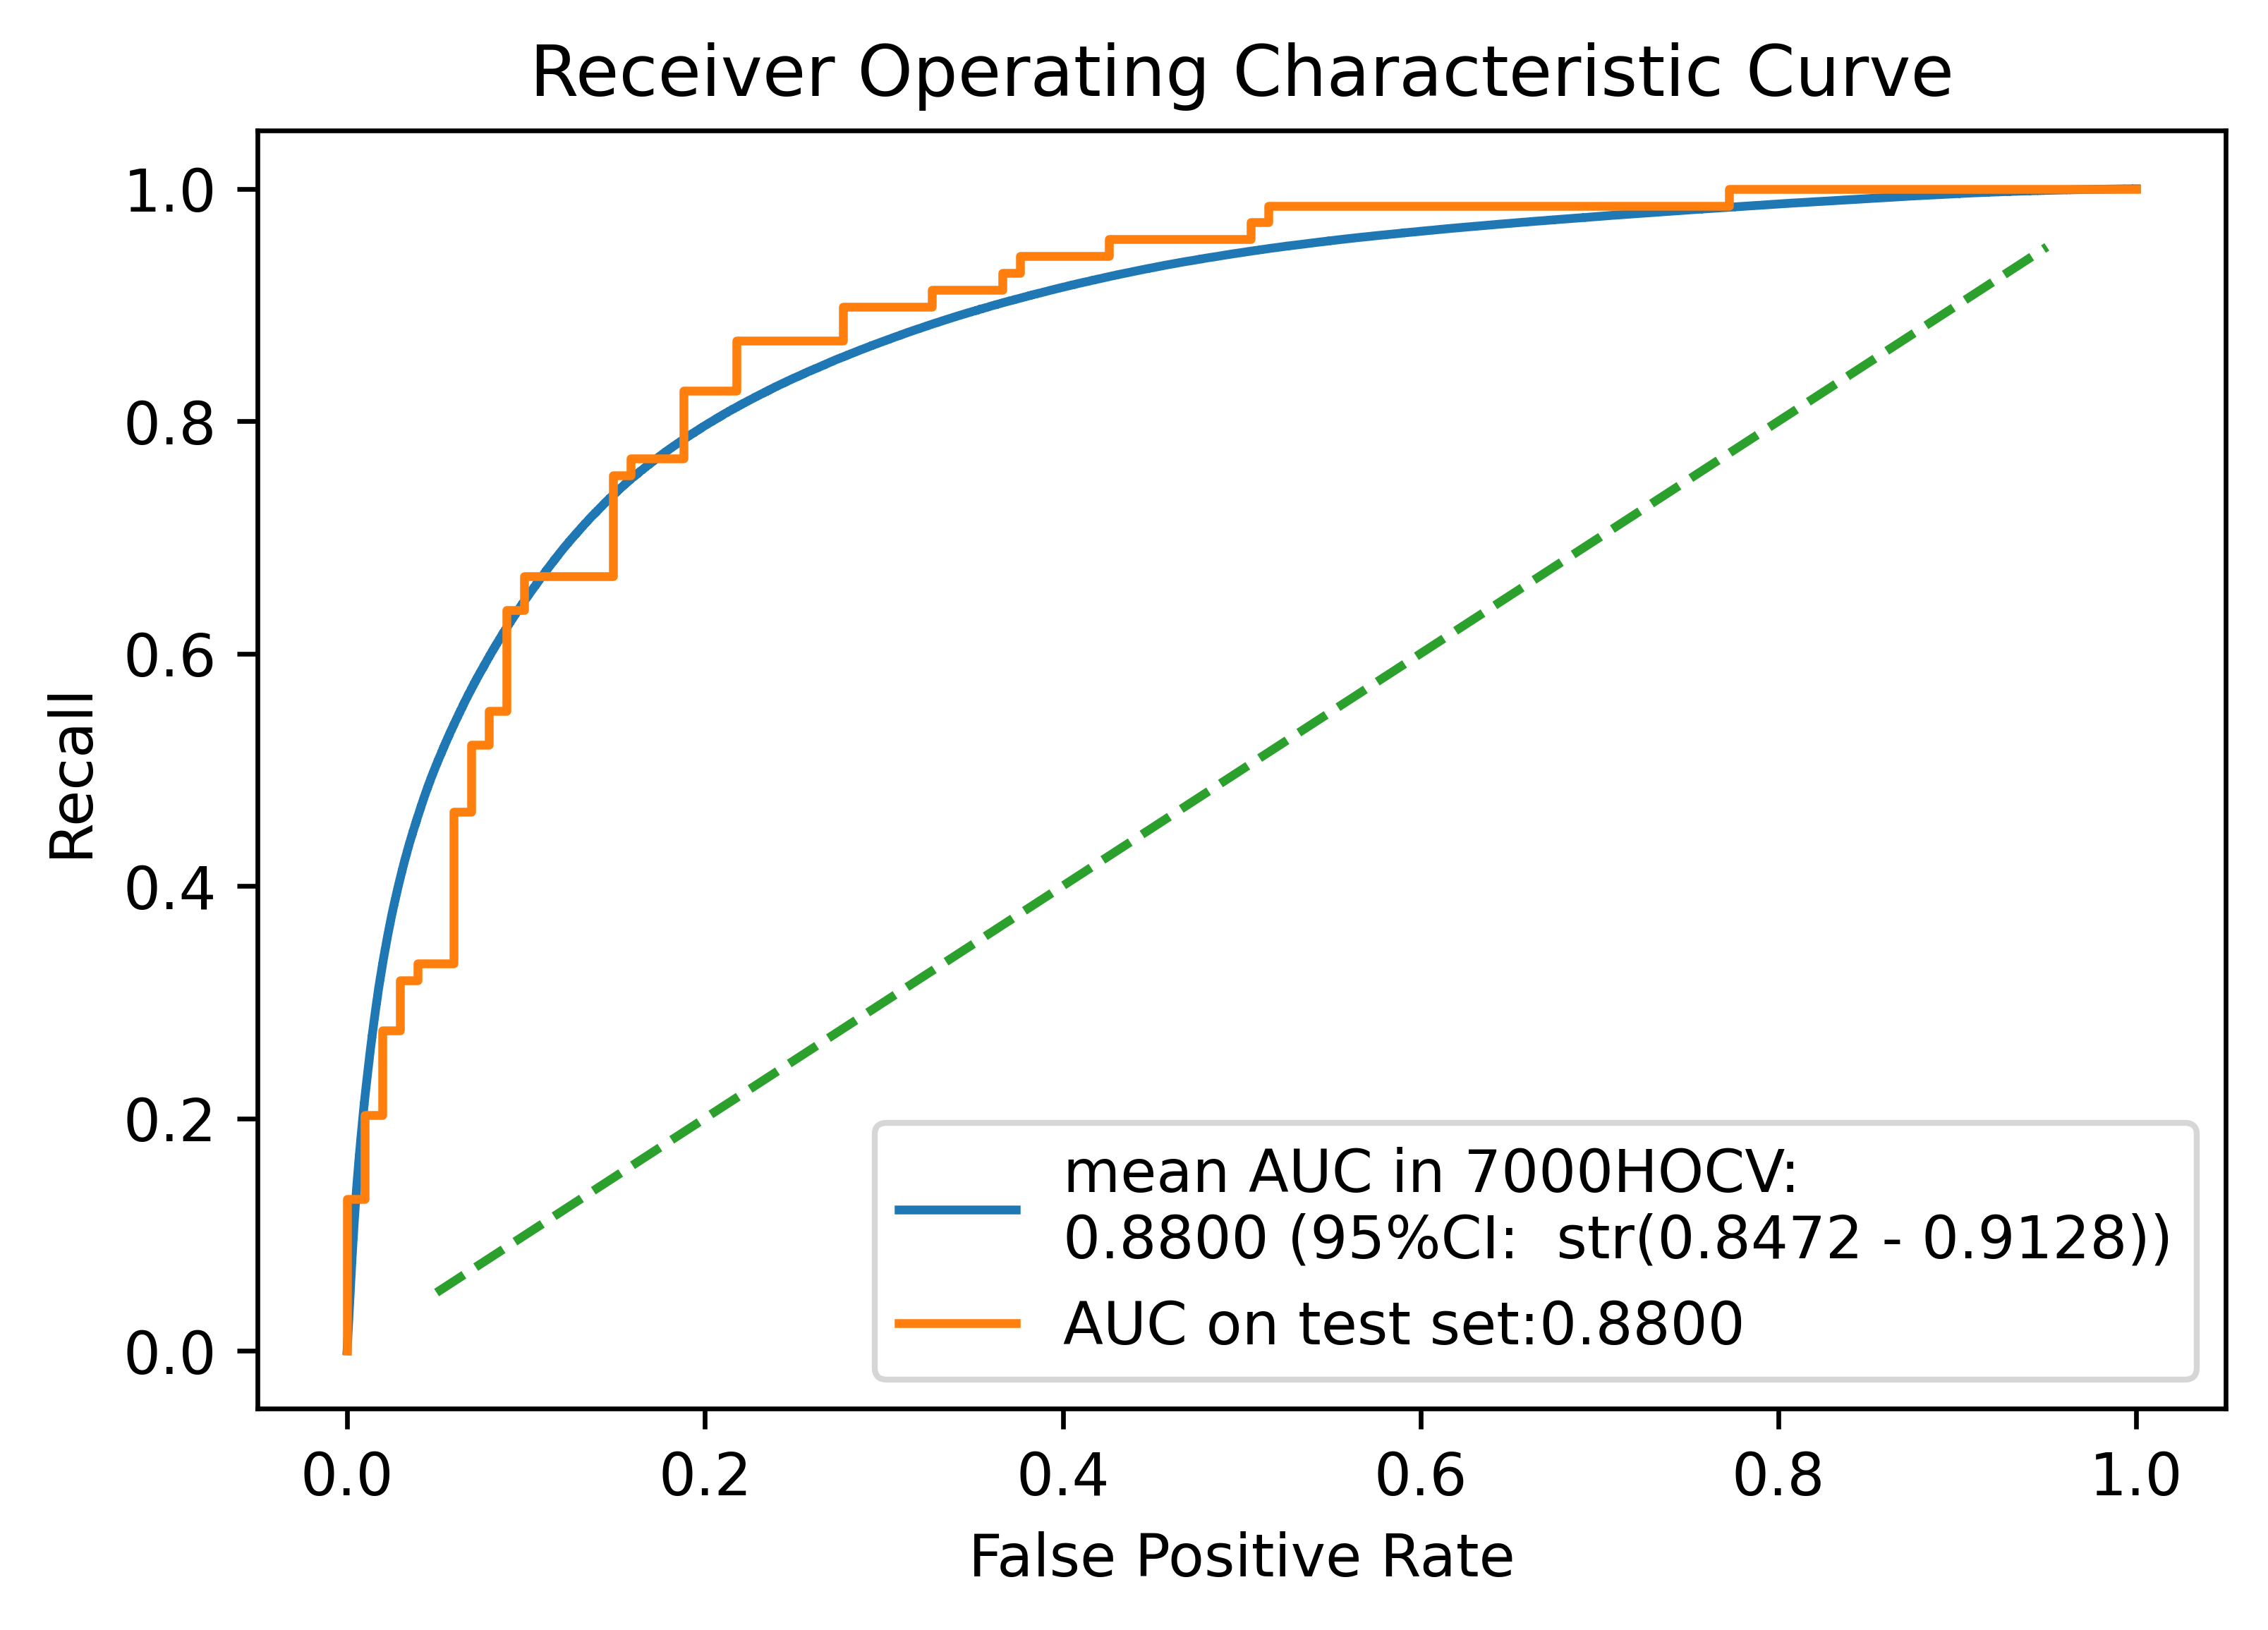

In [217]:
plt.figure(dpi = 600)   
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_HOCV,tpr_HOCV, label = 'mean AUC in 7000HOCV: \n' + str('%.4f'%auc_7000HOCV_mean) + ' (95%CI:  str(0.8472 - 0.9128))')
plt.plot(fpr_test,tpr_test, label = 'AUC on test set:' + str('%.4f'%auc_test))
plt.plot([0.05,0.95],[0.05,0.95],linestyle='--') #y=x,refference line
plt.legend(loc='lower right')
plt.savefig('/media/lee_ns/project/project/N10/figures/AUC.svg',bbox_inches='tight')
# plt.plot(fpr_test,tpr_test, label = 'AUC on test set: \n' + str('%.4f'%auc_test))

In [173]:
pr_HOCV,re_HOCV,thrpr_HOCV = metrics.precision_recall_curve(y_7000HOCV, prob_7000HOCV)

In [186]:
pr_test,re_test,thrpr_test = metrics.precision_recall_curve(y_2,prob_test[:,1])

In [179]:
prc = pd.DataFrame(columns = ['Precision', 'Recall'])
prc.loc[:, 'Precision'] = pr_HOCV
prc.loc[:, 'Recall'] = re_HOCV

In [188]:
metrics.auc(re_test,pr_test)

0.8175242702091055

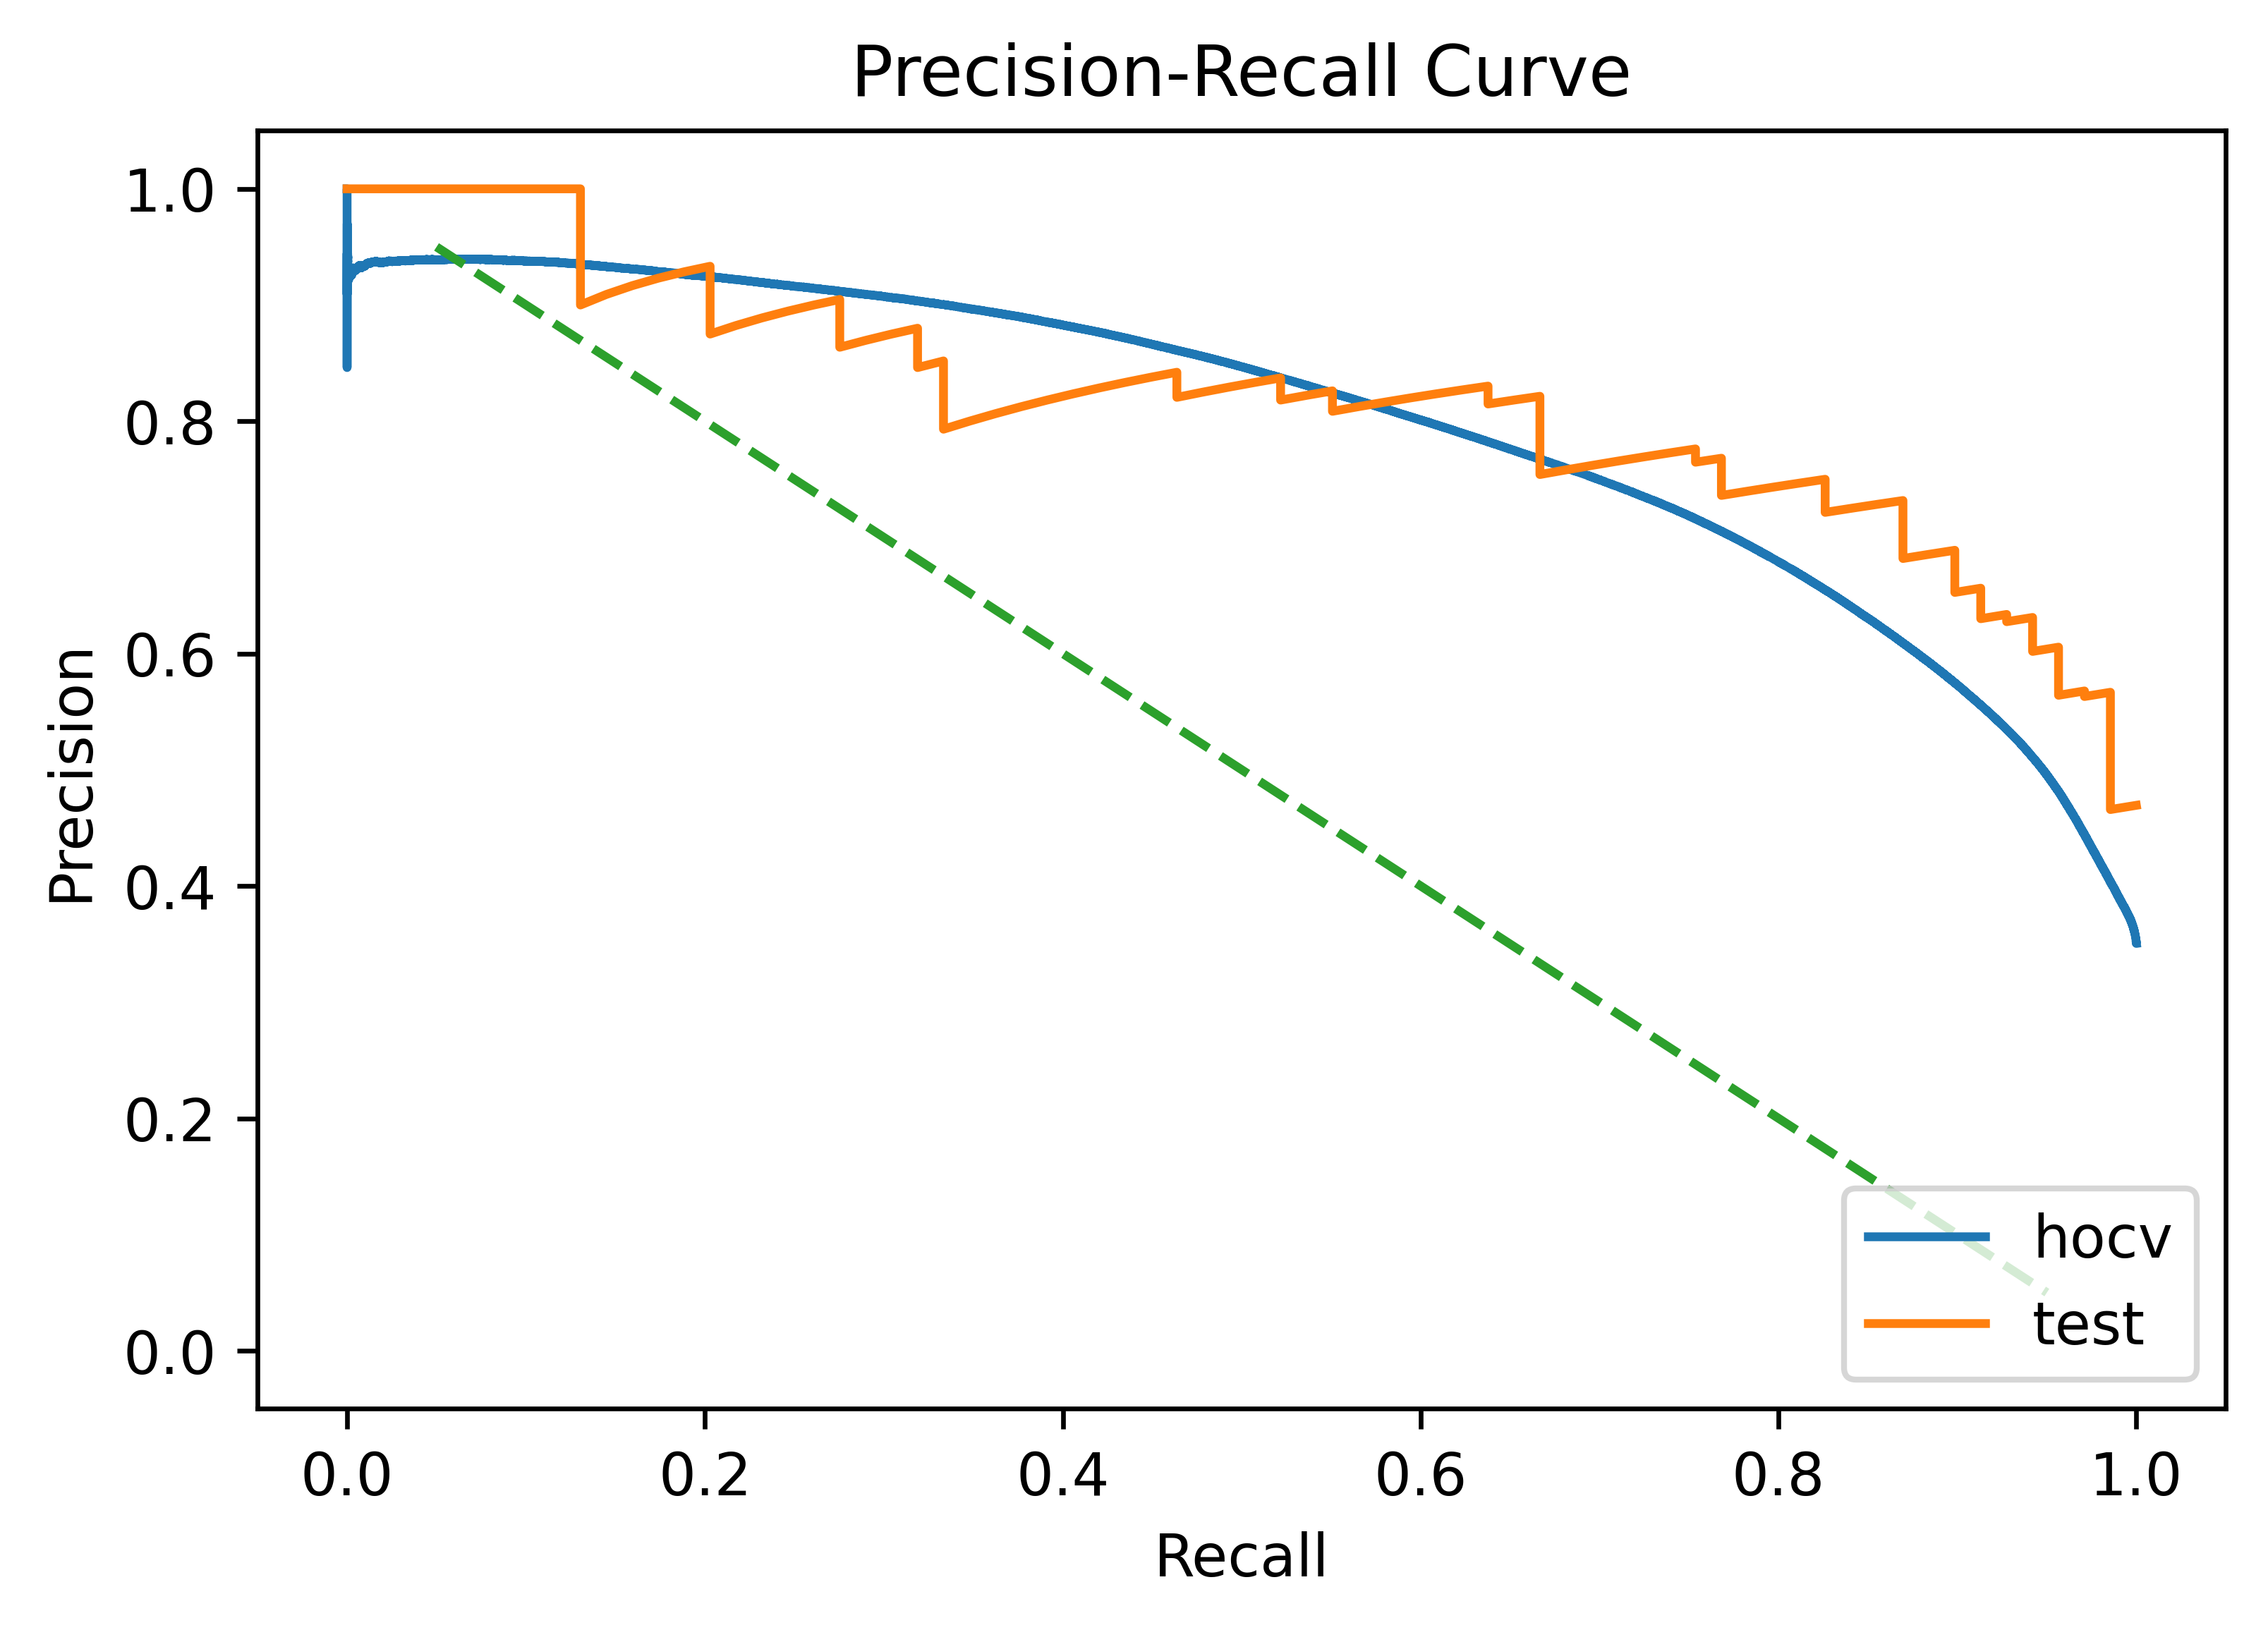

In [189]:
plt.figure(dpi = 600)   
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.plot(re_HOCV,pr_HOCV, label = 'hocv')#label = 'mean AUC in 7000HOCV: \n' + str('%.4f'%auc_7000HOCV_mean) + ' (95%CI:  str(0.8472 - 0.9128))'
plt.plot(re_test,pr_test, label = 'test')
# plt.plot(fpr_test,tpr_test, label = 'AUC on test set:' + str('%.4f'%auc_test))
plt.plot([0.05,0.95],[0.95,0.05],linestyle='--') #y=x,refference line
plt.legend(loc='lower right')

In [210]:
pro_y_test = pd.DataFrame(columns = ['y','prob','IDH'])
pro_y_test.loc[:,'y'] = y_2
pro_y_test.loc[:,'prob'] = prob_test[:,1]
pro_y_test.loc[:,'IDH'] = data_2.P_IDH

TypeError: savefig() missing 1 required positional argument: 'fname'

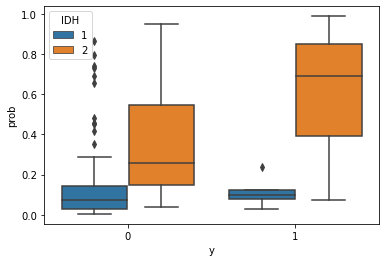

In [211]:
sns.boxplot(data = pro_y_test, x = 'y', y = 'prob',hue = 'IDH')
# plt.savefig()

In [207]:
cormat = pd.concat([x_2, pd.DataFrame(y_2, columns = ['HGG'])], axis =1).corr()

In [206]:
cormat

,S_NUM_S,S_H_T_RA,S_E_T,S_E_T_RA,AGE,S_H_T,S_M_T_RA,S_ET_RA,S_M_T,F,S_T,S_AP_T,I,SEX,S_ST,S_ABD_T,S_ET,R_T,HGG
0,4,0.000000,84.0,0.7,48,0.0,0.0,0.700000,0.0,1,120.00,1.0,1,1,120.0,0.0,84.0,0,0
1,1,0.000000,0.0,0.0,35,0.0,0.0,0.000000,0.0,0,0.33,0.0,1,1,0.0,0.0,0.0,0,0
2,2,1.000000,0.0,0.0,49,72.0,0.0,0.009722,0.0,1,72.00,0.0,0,2,72.0,0.7,0.7,0,1
3,1,0.000000,6.0,1.0,56,0.0,0.0,0.166667,0.0,0,6.00,0.0,1,1,6.0,0.0,1.0,0,1
4,3,0.666667,6.0,1.0,28,4.0,0.0,0.666667,0.0,0,6.00,0.0,1,1,6.0,0.0,4.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1,0.000000,0.5,1.0,32,0.0,0.0,0.000000,0.0,0,0.50,0.0,1,1,0.5,0.0,0.0,1,0
166,1,0.000000,0.0,0.0,45,0.0,0.0,0.000000,0.0,1,2.00,0.0,0,2,0.0,0.0,0.0,0,0
167,1,0.000000,6.0,1.0,31,0.0,0.0,0.116667,0.0,1,6.00,0.0,1,2,6.0,0.0,0.7,0,0
168,3,0.000000,0.0,0.0,49,0.0,1.0,0.500000,4.0,1,4.00,1.0,0,1,4.0,0.0,2.0,0,0


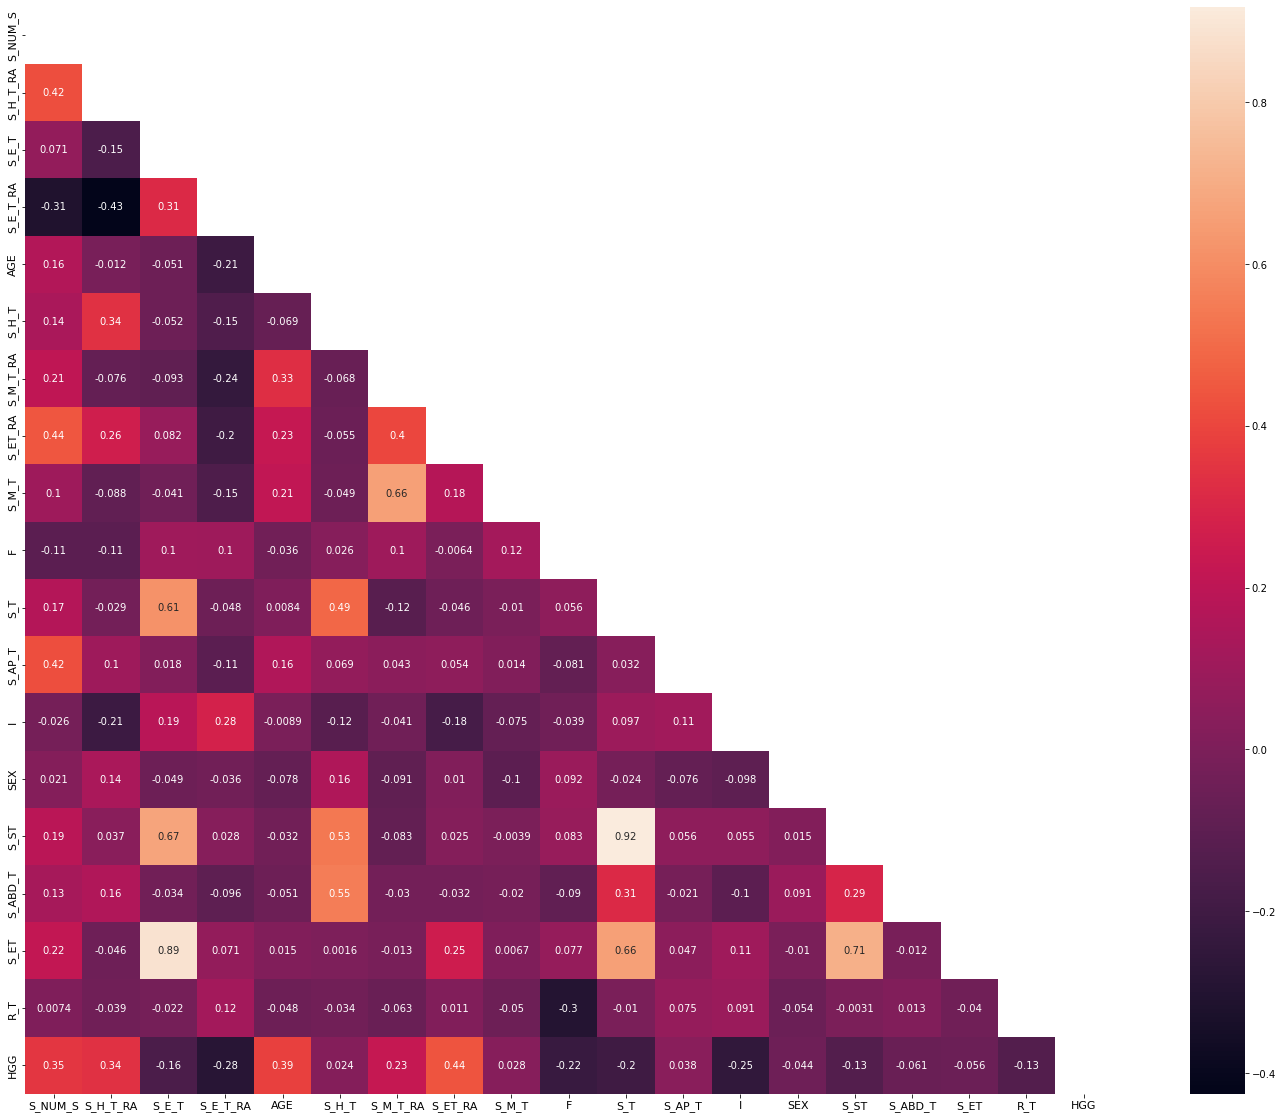

In [208]:
f, ax = plt.subplots(figsize = (28,20))
# cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True) 
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cormat, mask=mask, square=True, annot = True)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [ ]:
roc_data = pd.DataFrame()




label_i='pip'+str(i)+'\n(AUC='+str('%.4f'%auc)+'(95%CI,'+str('%.4f'%CI_2_5)+'-'+str('%.4f'%CI_97_5)+')'
plt.plot(fpr,recall,label=label_i)
plt.scatter(fpr[cut_index],recall[cut_index],s=30) #plt the cut_off point
plt.plot([0.05,0.95],[0.05,0.95],linestyle='--') #y=x,refference line
plt.legend(loc='lower right')

In [73]:
tpr

,Sensitivity
0,0.000000e+00
1,8.233794e-07
2,8.233794e-06
3,8.233794e-06
4,9.057173e-06
...,...
1242603,1.000000e+00
1242604,1.000000e+00
1242605,1.000000e+00
1242606,1.000000e+00


for IDH

In [3]:
# def for hyper-opt based on 100 HOCV
def hocv(params,n):
    x_train, x_val, y_train, y_val=train_test_split(train_data, train_label, train_size = 0.8, random_state= n, stratify= train_label)
    clf = XGBClassifier(n_estimators = int(params['n_estimators']), max_depth = int(params['max_depth']), 
                        learning_rate = params['learning_rate'], min_child_weight = int(params['min_child_weight']),
                        gamma = params['gamma'], subsample = params['subsample'], random_state = 123) # scale_pos_weight = 3.79,
    clf.fit(x_train,y_train)
    probs = clf.predict_proba(x_val)
    auc_n = metrics.roc_auc_score(y_val,probs[:, 1])
    return auc_n 
def hocv_(par):
    
    return hocv(par[0],par[1])
def hyperopt_xgb(params):
    par = list(itertools.product([params],range(100)))
    if __name__ == '__main__': 
        with mp.Pool() as pool:
            auc_i=pool.map(hocv_, par)
    auc_m = np.mean(auc_i)
    return -auc_m 
def param_hyperopt(max_eval=100):
    trials = Trials()
    # early_stop_f = no_progress_loss(100)
    params_best = fmin(hyperopt_xgb,
                       space = space4xgc,
                       max_evals = max_eval,
                       algo =tpe.suggest,
                       verbose = True,
                       trials = trials)
                       #early_stop_fn = early_stop_f)
    print('\n','\n','best params:', params_best,'\n')
    return params_best, trials

In [4]:
x_1 = deepcopy(data_1)
x_1 = x_1.drop(['P_TERT','P_CD','P_MGMT','GRADE',"ID"], axis = 1)
x_1 = x_1[x_1['P_IDH'] > 0]
y_1 = x_1['P_IDH']
x_1 = x_1.drop('P_IDH', axis = 1)
y_1 = np.squeeze(np.array(y_1))
y_1[y_1 == 1] = 0
y_1[y_1 == 2] = 1

print('count of IDH_mt:',sum(y_1 == 0), '\ncount of IDH_wt:', sum(y_1 == 1), '\n_mt / _wt:', sum(y_1 == 0) / sum(y_1 == 1))

count of IDH_mt: 374 
count of IDH_wt: 129 
_mt / _wt: 2.89922480620155


In [5]:
# initial hyperparameter space
n_list = list(range(100))
space4xgc = {
    'learning_rate': hp.uniform('learning_rate', 0.01,0.3),   
    'n_estimators': hp.quniform('n_estimators',50,500,25),  
    'max_depth': hp.quniform('max_depth',1,10,1),
    'min_child_weight':hp.quniform('min_child_weight',1,6,1),
    'gamma': hp.uniform('gamma',0,0.6),
    'subsample': hp.uniform('subsample',0.5,1)   
}  

In [6]:
train_data = x_1
train_label = y_1

In [7]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:40:46<00:00, 60.46s/trial, best loss: -0.8121487179487178]

 
 best params: {'gamma': 0.11590196925699622, 'learning_rate': 0.016390977925412716, 'max_depth': 2.0, 'min_child_weight': 4.0, 'n_estimators': 225.0, 'subsample': 0.887150382490346} 



In [17]:
clf= XGBClassifier(gamma = 0.1159, learning_rate = 0.0164, max_depth = 2, min_child_weight = 4, n_estimators = 225, subsample = 0.8872, random_state=123)
clf.fit(x_1, y_1)    
probs = clf.predict_proba(x_2)
auc_n = metrics.roc_auc_score(y_2,probs[:, 1])
print(auc_n)

0.8998460246360582


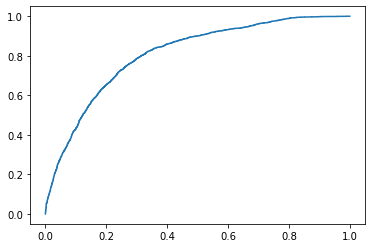

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
prob_df = []
y = []
clf = XGBClassifier(gamma = 0.1159, learning_rate = 0.0164, max_depth = 2, min_child_weight = 4, n_estimators = 225, subsample = 0.8872, random_state=123)
for i in range(100):
    x_train, x_val, y_train, y_val = train_test_split(train_data, train_label, train_size = 0.8, random_state= i, stratify= train_label)
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(x_val)
    probs = list(probs[:, 1])
    y_val = list(y_val)
    for n in range(len(y_val)):
        y.append(y_val[n])
        prob_df.append(probs[n])
fpr,recall,thread = metrics.roc_curve(y,prob_df) 
plt.plot(fpr,recall)
plt.show()

In [13]:
clf= XGBClassifier(gamma = 0.24, learning_rate = 0.05, max_depth = 1, min_child_weight = 2, n_estimators = 450, subsample = 0.59, random_state=123)
clf.fit(x_1, y_1)    
probs = clf.predict_proba(x_2)
auc_n = metrics.roc_auc_score(y_2,probs[:, 1])
print(auc_n)

0.896976483762598


In [12]:
x_2 = deepcopy(data_2)
x_2 = x_2.drop(['P_TERT','P_CD','P_MGMT','GRADE',"ID"], axis = 1)
y_2 = x_2['P_IDH']
x_2 = x_2.drop('P_IDH', axis = 1)
y_2 = np.squeeze(np.array(y_2))
y_2[y_2 == 1] = 0
y_2[y_2 == 2] = 1

In [15]:
x_3 = deepcopy(data_3)
x_3 = x_3.drop(['P_TERT','P_CD','P_MGMT','GRADE',"ID"], axis = 1)
y_3 = x_3['P_IDH']
x_3 = x_3.drop('P_IDH', axis = 1)
y_3 = np.squeeze(np.array(y_3))
y_3[y_3 == 1] = 0
y_3[y_3 == 2] = 1

In [16]:
clf= XGBClassifier(gamma = 0.24, learning_rate = 0.05, max_depth = 1, min_child_weight = 2, n_estimators = 450, subsample = 0.59, random_state=123)
clf.fit(x_1, y_1)    
probs = clf.predict_proba(x_3)
auc_n = metrics.roc_auc_score(y_3,probs[:, 1])
print(auc_n)

0.8282247765006385


In [18]:
clf= XGBClassifier(gamma = 0.1159, learning_rate = 0.0164, max_depth = 2, min_child_weight = 4, n_estimators = 225, subsample = 0.8872, random_state=123)
clf.fit(x_1, y_1)    
probs = clf.predict_proba(x_3)
auc_n = metrics.roc_auc_score(y_3,probs[:, 1])
print(auc_n)

0.8623882503192848


In [ ]:
params_best, trials = param_hyperopt(100)

In [9]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:43:11<00:00, 61.91s/trial, best loss: -0.8171499999999999]

 
 best params: {'gamma': 0.461539814411314, 'learning_rate': 0.0103029638907099, 'max_depth': 2.0, 'min_child_weight': 4.0, 'n_estimators': 325.0, 'subsample': 0.5008844908020336} 



In [10]:
# hyperparameter space for fine tuning
n_list = list(range(100))
space4xgc = {
    'learning_rate': hp.uniform('learning_rate', 0.001,0.03),   
    'n_estimators': hp.quniform('n_estimators',250,400,25),  
    'max_depth': hp.quniform('max_depth',1,3,1),
    'min_child_weight':hp.quniform('min_child_weight',3,6,1),
    'gamma': hp.uniform('gamma',0,0.3),
    'subsample': hp.uniform('subsample',0.5,0.7)   
}  

In [11]:
params_best, trials = param_hyperopt(100)

100%|████| 100/100 [1:40:30<00:00, 60.30s/trial, best loss: -0.8184033333333335]

 
 best params: {'gamma': 0.20478013731769898, 'learning_rate': 0.006813443484501714, 'max_depth': 2.0, 'min_child_weight': 3.0, 'n_estimators': 350.0, 'subsample': 0.5011907156489565} 



In [9]:
params_best, trials = param_hyperopt(100)

100%|███████████████| 100/100 [1:15:29<00:00, 45.30s/trial, best loss: -0.81377]

 
 best params: {'gamma': 0.12286243505311606, 'learning_rate': 0.0389889088521623, 'max_depth': 2.0, 'min_child_weight': 1.0, 'n_estimators': 50.0, 'subsample': 0.509558323215854} 



In [20]:
def hocv(params,n):
    x_train, x_val, y_train, y_val=train_test_split(train_data, train_label, train_size = 0.8, random_state= n, stratify= train_label)
    clf = XGBClassifier(n_estimators = int(params['n_estimators']), max_depth = int(params['max_depth']), 
                        learning_rate = params['learning_rate'], min_child_weight = int(params['min_child_weight']),
                        gamma = params['gamma'], subsample = params['subsample'],
                        random_state = 123)
    clf.fit(x_train,y_train)
    probs = clf.predict_proba(x_val)
    auc_n = metrics.roc_auc_score(y_val,probs[:, 1])
    # cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=123) 
    # auc_val = cross_validate(clf, x_train, y_train, scoring ='roc_auc', cv= cv_inner, verbose = False, n_jobs = -1, error_score = 'raise')
    # auc_n = np.mean(auc_val['test_score'])
    return auc_n 
def hocv_(par):
    
    return hocv(par[0],par[1])
def hyperopt_xgb(params):
    par = list(itertools.product([params],range(100)))
    if __name__ == '__main__': 
        with mp.Pool() as pool:
            auc_i=pool.map(hocv_, par)
    auc_m = np.mean(auc_i)
    return -auc_m 
def param_hyperopt(max_eval=100):
    trials = Trials()
    # early_stop_f = no_progress_loss(100)
    params_best = fmin(hyperopt_xgb,
                       space = space4xgc,
                       max_evals = max_eval,
                       algo =tpe.suggest,
                       verbose = True,
                       trials = trials)
                       #early_stop_fn = early_stop_f)
    print('\n','\n','best params:', params_best,'\n')
    return params_best, trials

In [10]:
n_list = list(range(100))
space4xgc = {
    'learning_rate': hp.uniform('learning_rate', 0.01,0.1),   
    'n_estimators': hp.quniform('n_estimators',50,500,25),  
    'max_depth': hp.quniform('max_depth',1,5,1),
    'min_child_weight':hp.quniform('min_child_weight',1,6,1),
    'gamma': hp.uniform('gamma',0,0.3),
    'subsample': hp.uniform('subsample',0.5,1)   
}  

In [7]:
def hocv(params,n):
    x_train, x_val, y_train, y_val=train_test_split(train_data, train_label, train_size = 0.8, random_state= n, stratify= train_label)
    clf = XGBClassifier(n_estimators = int(params['n_estimators']), max_depth = int(params['max_depth']), 
                        learning_rate = params['learning_rate'], min_child_weight = int(params['min_child_weight']),
                        gamma = params['gamma'], subsample = params['subsample'],
                        random_state = 123, scale_pos_weight = 3.79)
    clf.fit(x_train,y_train)
    probs = clf.predict_proba(x_val)
    auc_n = metrics.roc_auc_score(y_val,probs[:, 1])
    # cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=123) 
    # auc_val = cross_validate(clf, x_train, y_train, scoring ='roc_auc', cv= cv_inner, verbose = False, n_jobs = -1, error_score = 'raise')
    # auc_n = np.mean(auc_val['test_score'])
    return auc_n 
def hocv_(par):
    
    return hocv(par[0],par[1])
def hyperopt_xgb(params):
    par = list(itertools.product([params],range(100)))
    if __name__ == '__main__': 
        with mp.Pool() as pool:
            auc_i=pool.map(hocv_, par)
    auc_m = np.mean(auc_i)
    return -auc_m 
def param_hyperopt(max_eval=100):
    trials = Trials()
    # early_stop_f = no_progress_loss(100)
    params_best = fmin(hyperopt_xgb,
                       space = space4xgc,
                       max_evals = max_eval,
                       algo =tpe.suggest,
                       verbose = True,
                       trials = trials)
                       #early_stop_fn = early_stop_f)
    print('\n','\n','best params:', params_best,'\n')
    return params_best, trials

In [8]:
params_best, trials = param_hyperopt(20)

100%|████████| 20/20 [19:55<00:00, 59.78s/trial, best loss: -0.8102933333333333]

 
 best params: {'gamma': 0.3724093119210236, 'learning_rate': 0.11962815867069848, 'max_depth': 2.0, 'min_child_weight': 3.0, 'n_estimators': 50.0, 'subsample': 0.5446256236278915} 



for grade

In [3]:
# def for hyper-opt based on 100 HOCV
def hocv(params,n):
    x_train, x_val, y_train, y_val=train_test_split(train_data_g, train_label_g, train_size = 0.8, random_state= n, stratify= train_label_g)
    clf = XGBClassifier(n_estimators = int(params['n_estimators']), max_depth = int(params['max_depth']), 
                        learning_rate = params['learning_rate'], min_child_weight = int(params['min_child_weight']),
                        gamma = params['gamma'], subsample = params['subsample'], random_state = 123) # scale_pos_weight = 3.79
    clf.fit(x_train,y_train)
    probs = clf.predict_proba(x_val)
    auc_n = metrics.roc_auc_score(y_val,probs[:, 1])
    return auc_n 
def hocv_(par):
    
    return hocv(par[0],par[1])
def hyperopt_xgb(params):
    par = list(itertools.product([params],range(100)))
    if __name__ == '__main__': 
        with mp.Pool() as pool:
            auc_i=pool.map(hocv_, par)
    auc_m = np.mean(auc_i)
    return -auc_m 
def param_hyperopt(max_eval=100):
    trials = Trials()
    # early_stop_f = no_progress_loss(100)
    params_best = fmin(hyperopt_xgb,
                       space = space4xgc,
                       max_evals = max_eval,
                       algo =tpe.suggest,
                       verbose = True,
                       trials = trials)
                       #early_stop_fn = early_stop_f)
    print('\n','\n','best params:', params_best,'\n')
    return params_best, trials

In [4]:
x_1_g = deepcopy(data_1)
x_1_g = x_1_g.drop(['P_TERT','P_CD','P_MGMT','P_IDH',"ID"], axis = 1)
y_1_g = x_1_g['GRADE']
x_1_g = x_1_g.drop('GRADE', axis = 1)
y_1_g = np.squeeze(np.array(y_1_g))
y_1_g[y_1_g < 4] = 0  #LGGs
y_1_g[y_1_g == 4] = 1 #HGGs

print('count of LGGs:',sum(y_1_g == 0), '\ncount of HGGs:', sum(y_1_g == 1), '\nLGGs / HGGs:', sum(y_1_g == 0) / sum(y_1_g == 1))

count of LGGs: 645 
count of HGGs: 348 
LGGs / HGGs: 1.853448275862069


In [5]:
# initial hyperparameter space
n_list = list(range(100))
space4xgc = {
    'learning_rate': hp.uniform('learning_rate', 0.01,0.3),   
    'n_estimators': hp.quniform('n_estimators',50,500,25),  
    'max_depth': hp.quniform('max_depth',1,10,1),
    'min_child_weight':hp.quniform('min_child_weight',1,6,1),
    'gamma': hp.uniform('gamma',0,0.6),
    'subsample': hp.uniform('subsample',0.5,1)   
}  

In [6]:
train_data_g = x_1_g
train_label_g = y_1_g

In [7]:
params_best, trials = param_hyperopt(100)

100%|███| 100/100 [7:08:14<00:00, 256.94s/trial, best loss: -0.8823615725359911]

 
 best params: {'gamma': 0.24181696658261892, 'learning_rate': 0.047836694849998807, 'max_depth': 1.0, 'min_child_weight': 2.0, 'n_estimators': 450.0, 'subsample': 0.586385532765944} 

